In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError
from pathlib import Path

import torch.nn
import torchvision
import tensorflow as tf
import torchvision.transforms as transforms
import keras.optimizers
from tensorflow.keras import initializers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, Dropout

In [2]:
# Specify csv file with humidity temperature and picture information
df = pd.read_csv("./data/output_10000.csv")
# The 5 columns here can use humidity and temperature
print(df.shape)
df.head()

(10000, 5)


,stationId,imageDate,imgPath,humidity,temperature C 2m
0,1193-0,6/12/2018 14:01,1193-0/93/1544104893_1193-0.jpg,99.3,0.0
1,1239-0,14/12/2018 10:50,1239-0/24/1544784624_1239-0.jpg,91.9,-1.2
2,1193-0,6/03/2019 8:14,1193-0/41/1551860041_1193-0.jpg,98.3,2.3
3,1154-0,7/03/2019 10:25,1154-0/30/1551954330_1154-0.jpg,64.0,10.2
4,1163-1,21/11/2018 10:45,1163-1/26/1542797126_1163-1.jpg,90.7,-0.1


In [3]:
#finds nth occurence of character in a string
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

In [4]:
import warnings
warnings.filterwarnings('ignore')

faults = []
#first drop rows that have faulty images
for i in range(10000-1, -1, -1):
    
    imgPath = "./data/save_10000/" + df.iloc[i, 2]
    df.iloc[i][2] = imgPath

    j = find_nth(imgPath, "/", 6)
    if imgPath[j+1] == "0":
        imgPath = imgPath[:j+1] + imgPath[j+2:]
    try:
        img = Image.open(Path(imgPath))
        df.iloc[i, 2] = imgPath
        
        
    except:
        faultyPaths.append(imgPath)
        df.drop(i, inplace = True)

In [5]:
df.shape

(8374, 5)

In [6]:
df.head()

,stationId,imageDate,imgPath,humidity,temperature C 2m
0,1193-0,6/12/2018 14:01,./data/save_10000/1193-0/93/1544104893_1193-0.jpg,99.3,0.0
1,1239-0,14/12/2018 10:50,./data/save_10000/1239-0/24/1544784624_1239-0.jpg,91.9,-1.2
2,1193-0,6/03/2019 8:14,./data/save_10000/1193-0/41/1551860041_1193-0.jpg,98.3,2.3
3,1154-0,7/03/2019 10:25,./data/save_10000/1154-0/30/1551954330_1154-0.jpg,64.0,10.2
4,1163-1,21/11/2018 10:45,./data/save_10000/1163-1/26/1542797126_1163-1.jpg,90.7,-0.1


In [7]:
sample1000 = df.sample(frac = (8000 / 8374))
print(sample1000.shape)
sample1000.head()

(8000, 5)


,stationId,imageDate,imgPath,humidity,temperature C 2m
4063,1489-1,29/11/2018 13:07,./data/save_10000/1489-1/60/1543496860_1489-1.jpg,54.7,-2.9
554,1241-0,7/02/2019 13:30,./data/save_10000/1241-0/59/1549546259_1241-0.jpg,40.3,6.8
6999,1454-0,14/12/2018 9:27,./data/save_10000/1454-0/57/1544779657_1454-0.jpg,90.2,-1.2
7227,1156-1,7/02/2019 14:45,./data/save_10000/1156-1/24/1549550724_1156-1.jpg,58.0,2.8
2993,1428-0,30/12/2018 10:32,./data/save_10000/1428-0/21/1546165921_1428-0.jpg,89.5,4.9


In [8]:
transformation = torchvision.transforms.Compose([
        transforms.Resize((256, 256)),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

temp -2.9
path ./data/save_10000/1489-1/60/1543496860_1489-1.jpg


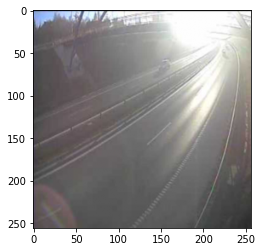

temp 7.8
path ./data/save_10000/1241-0/45/1551606945_1241-0.jpg


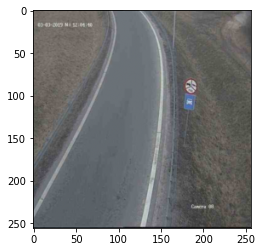

temp 2.1
path ./data/save_10000/103-0/68/1551518068_103-0.jpg


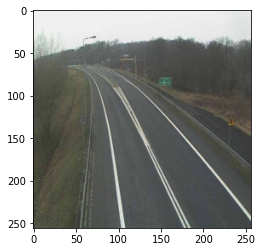

temp 0.1
path ./data/save_10000/1498-0/87/1545659087_1498-0.jpg


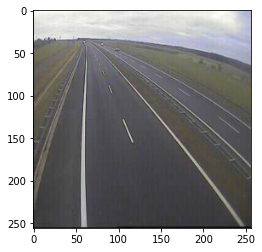

temp 8.2
path ./data/save_10000/1114-0/40/1552122840_1114-0.jpg


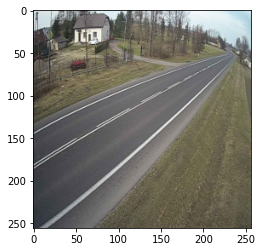

temp 6.6
path ./data/save_10000/1193-1/41/1551885241_1193-1.jpg


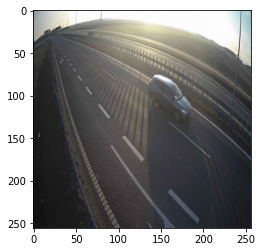

temp 3.8
path ./data/save_10000/1492-1/28/1549979128_1492-1.jpg


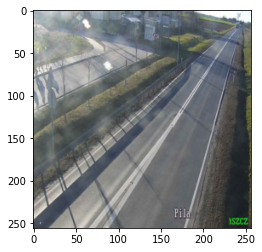

temp 3.3
path ./data/save_10000/1248-1/37/1543745437_1248-1.jpg


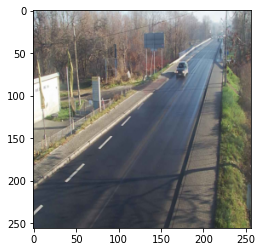

In [9]:
humidityFeature = np.asarray(sample1000["humidity"])
temperatureFeature = np.asarray(sample1000["temperature C 2m"])

imgFeature = []
imgPaths = sample1000["imgPath"]
for i in range(sample1000.shape[0]):
    imgPath = sample1000.iloc[i, 2]
    
    #resize and normalise
    img = Image.open(Path(imgPath))
    img = img.convert('RGB')
    transformedImg = transformation(img)
    transformedImg = np.asarray(transformedImg)
    transformedImg = transformedImg / 255
    
    imgFeature.append(transformedImg)
    
    if i % 1000 == 0:
        print("temp {}".format(sample1000.iloc[i, 4]))
        print("path {}".format(sample1000.iloc[i, 2]))
        
        plt.imshow(transformedImg)
        plt.show()
    
imgFeature = np.asarray(imgFeature)
#example image

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(imgFeature, temperatureFeature, test_size=0.10)
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_test = np.asarray(X_test)
Y_test = np.asarray(Y_test)

In [11]:
#define a simple model
image_input = Input(batch_size=8, shape=(256, 256, 3))
conv1 = Conv2D(32, (3, 3), 1, padding="same", activation='relu')(image_input)
conv2 = Conv2D(64, (3, 3), 1, activation='relu')(conv1)
maxpool1 = MaxPooling2D((2, 2))(conv2)
dropout = Dropout(0.25)(maxpool1)

flatten = Flatten()(dropout)
image_dense = Dense(128, activation='relu')(flatten)
output = Dense(1, activation='linear')(image_dense)

model = Model(inputs=image_input, outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error') 

print(model.summary())

history = model.fit(X_train, Y_train, validation_split=0.1, epochs=8, batch_size=8, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(8, 256, 256, 3)]        0         
                                                                 
 conv2d (Conv2D)             (8, 256, 256, 32)         896       
                                                                 
 conv2d_1 (Conv2D)           (8, 254, 254, 64)         18496     
                                                                 
 max_pooling2d (MaxPooling2  (8, 127, 127, 64)         0         
 D)                                                              
                                                                 
 dropout (Dropout)           (8, 127, 127, 64)         0         
                                                                 
 flatten (Flatten)           (8, 1032256)              0         
                                                             

NameError: name 'pickle' is not defined

In [12]:
import pickle
filename = 'originalSample_CNN.sav'
pickle.dump(model, open(filename, 'wb'))

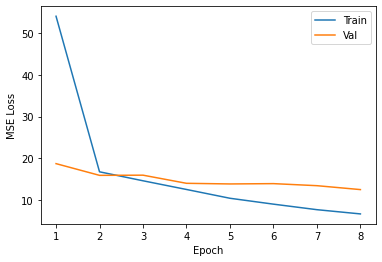

In [14]:
#just plot epochs 2-5
epochs = np.arange(1,9)
plt.plot(epochs, history.history['loss'][:])
plt.plot(epochs, history.history['val_loss'][:])
plt.legend(["Train", "Val"])
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [15]:
#compare predictions with baseline that uses training set and outputs mean temperature
Y_pred = np.transpose(np.asarray(model.predict(X_test)))[0]
Y_base = [np.mean(Y_train) for i in range(len(X_test))]

rmse = np.sqrt(((Y_test - Y_base)**2).mean(axis=0))
print("Base RMSE {}".format(rmse))
rmse = np.sqrt(((Y_test - Y_pred)**2).mean(axis=0))
print("Model RMSE {}".format(rmse))

#print some sample predictions
numPreds = len(Y_test)
print("True \t Pred")
for i in range(25):
    print("{} \t {}".format(Y_test[i], np.round(Y_pred[i], 1)))

25/25 [==============================] - 15s 452ms/step
Base RMSE 4.274916620459716
Model RMSE 3.6111143230050184
True 	 Pred
5.6 	 4.099999904632568
5.5 	 5.400000095367432
3.4 	 8.899999618530273
3.2 	 6.099999904632568
3.1 	 6.599999904632568
1.6 	 6.800000190734863
-1.4 	 1.2000000476837158
4.6 	 2.5
-0.8 	 1.0
1.6 	 0.8999999761581421
7.7 	 3.5
2.5 	 6.800000190734863
4.4 	 5.0
8.8 	 5.199999809265137
-1.0 	 2.5
0.1 	 -0.8999999761581421
9.9 	 9.100000381469727
3.6 	 3.799999952316284
5.7 	 2.799999952316284
1.4 	 6.400000095367432
0.9 	 3.5999999046325684
0.0 	 2.799999952316284
14.5 	 9.300000190734863
4.5 	 2.0999999046325684
1.6 	 1.899999976158142


3.5398579 -8.2


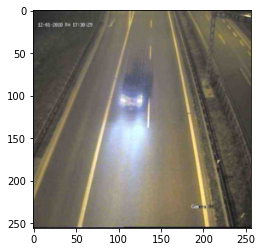

25.190485 8.5


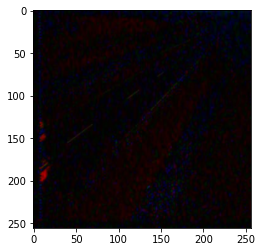

3.5873654 14.2


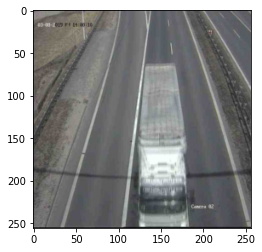

0.036440358 -11.6


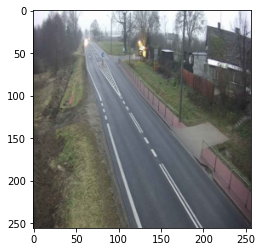

6.085837 -5.2


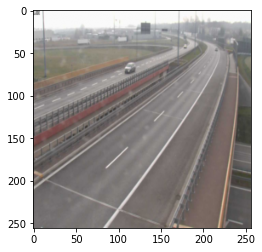

3.9462576 15.2


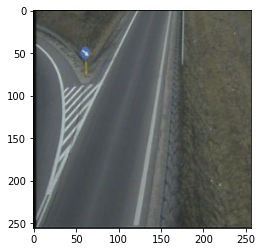

5.452995 16.0


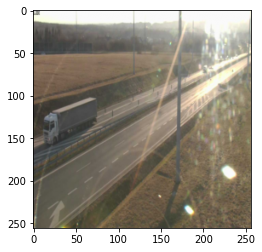

In [20]:
for i in range(len(Y_pred)):
    if abs(Y_pred[i] - Y_test[i]) > 10:
        print(Y_pred[i], Y_test[i])
        #img = transforms.ToPILImage()(X_test[i])
        plt.imshow(X_test[i])
        plt.show()

In [16]:
#sort true,estimate pairs by order of lowest true
estimates = [(Y_test[i], Y_pred[i]) for i in range(numPreds)]
estimates.sort(key=lambda x:x[0])
print(estimates[0:10])

[(-11.6, 0.036440358), (-8.2, 3.5398579), (-5.9, -1.0368373), (-5.3, 0.6014745), (-5.2, 3.036911), (-5.2, 6.085837), (-5.2, 4.50584), (-4.6, -2.1851017), (-4.6, 0.2834692), (-4.4, 0.5214096)]


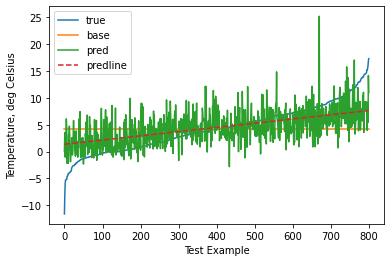

In [17]:
x = np.arange(numPreds)
y1 = [estimates[i][0] for i in range(numPreds)]
y2 = [estimates[i][1] for i in range(numPreds)]

plt.plot(x, y1)
plt.plot(x, Y_base)
plt.plot(x, y2)
yfit = np.polyfit(x, y2, 3)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y2, 1))(np.unique(x)), '--')
plt.xlabel("Test Example")
plt.ylabel("Temperature, deg Celsius")
plt.legend(["true", "base", "pred", "predline"])
plt.show()